## Data preparation

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

DATASET_DIR = (Path("..") / "datasets").resolve()
DATASETS = ["OFFICE-MANNERSDB", "MANNERSDBPlus"]
LABEL_COLS = [
    "Vaccum Cleaning", "Mopping the Floor", "Carry Warm Food",
    "Carry Cold Food", "Carry Drinks", "Carry Small Objects",
    "Carry Large Objects", "Cleaning", "Starting a conversation"
]

In [ ]:
def process_csv(csv_path, dataset):
    """Process individual CSV files"""
    df = pd.read_csv(csv_path)
    df = df.drop(columns=df.columns[-1])
    
    # Extract metadata from first column
    first_col = df.columns[0]
    split_data = df[first_col].str.split('_', n=2, expand=True)
    
    df["robot"] = split_data[0]
    df["domain"] = split_data[1]
    df["image_ref"] = split_data[2].astype(int)
    df["dataset"] = dataset

    df = df.drop(columns=[first_col])
    
    return df

def consolidate_data(datasets):
    """Aggregate all CSVs"""
    all_dfs = []
    for dataset in datasets:
        source_path = DATASET_DIR / dataset
        
        for robot in ["NAO", "Pepper", "PR2"]:
            ann_dir = source_path / robot / "Annotations"
            if not ann_dir.exists():
                raise ValueError(f"Labels csv file path ({ann_dir}) doesn't exist")
                
            
            for csv_file in ann_dir.glob("*.csv"):
                try:
                    df = process_csv(csv_file, dataset)
                    all_dfs.append(df)
                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")
    
    df = pd.concat(all_dfs, ignore_index=True)

    return df

In [ ]:
def validate_raw_data(df):
    """Comprehensive data quality checks for raw annotation data"""
    required_columns = {'robot', 'domain', 'image_ref', 'dataset'}

    # Check for any missing columns
    missing_cols = required_columns - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Label value validation (should be between 1 and 5)
    for col in LABEL_COLS:
        if df[col].min() < 1 or df[col].max() > 5:
            raise ValueError(f"Label {col} has invalid range [{df[col].min()}, {df[col].max()}]")

    # Null values check
    null_cols = df.columns[df.isnull().any()].tolist()
    if null_cols:
        raise ValueError(f"Null values found in columns: {null_cols}")

    # Data type and value validation for image_ref
    if not pd.api.types.is_integer_dtype(df['image_ref']):
        raise TypeError("image_ref must be integer type")
    if (df['image_ref'] < 0).any():
        raise ValueError("image_ref contains negative values, which is invalid")

    # Categorical value validation
    valid_robots = {'NAO', 'Pepper', 'PR2'}
    invalid_robots = set(df['robot']) - valid_robots
    if invalid_robots:
        raise ValueError(f"Invalid robot values: {invalid_robots}")

    valid_sources = {'OFFICE-MANNERSDB', 'MANNERSDBPlus'}
    invalid_sources = set(df['dataset']) - valid_sources
    if invalid_sources:
        raise ValueError(f"Invalid source directories: {invalid_sources}")

    return True


In [ ]:
def aggregate_labels(df):
    """Aggregate multiple annotations per image by image path"""    
    agg_dict = {
        **{col: 'mean' for col in LABEL_COLS},
        **{col: 'first' for col in df.columns.difference(LABEL_COLS).tolist()},
    }
    
    return df.groupby('image_path', as_index=False).agg(agg_dict)


In [5]:
def resolve_image_path(row):
    """Robust path resolution with validation"""
    base_dir = DATASET_DIR / row['dataset'] / row['robot'] / "Images"
    
    if row['dataset'] == "OFFICE-MANNERSDB":
        target = base_dir / f"{row['domain']}_{row['image_ref']}.png"
    else:
        target = next(base_dir.glob(f"{row['image_ref']}_*.png"), None)
    
    if target and target.exists():
        return target.resolve()
    return None

In [ ]:
class ImageLabelDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = str(self.df.at[idx, "image_path"])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Error loading {img_path}: {str(e)}")
        
        labels = self.df.iloc[idx][LABEL_COLS].values.astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.from_numpy(labels)

In [ ]:
def create_dataloaders(df, batch_sizes=(32, 64, 64)):
    """Create train/val/test dataloaders using image_path as unique key"""
    #TODO we have to be able to create separate datasets for each domain
    #TODO we have to be able to combine old samples with new ones into a new dataset
    
    # Get unique image paths
    unique_images = df[['image_path']].reset_index(drop=True)
    
    # Split using image_path as key
    train_paths, temp_paths = train_test_split(
        unique_images['image_path'], 
        test_size=0.3, 
        random_state=42
    )
    val_paths, test_paths = train_test_split(
        temp_paths,
        test_size=0.5, 
        random_state=42
    )
   
    # Create subsets
    train_df = df[df['image_path'].isin(train_paths)].reset_index(drop=True)
    val_df = df[df['image_path'].isin(val_paths)].reset_index(drop=True)
    test_df = df[df['image_path'].isin(test_paths)].reset_index(drop=True)
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = ImageLabelDataset(train_df, transform)
    val_dataset = ImageLabelDataset(val_df, transform)
    test_dataset = ImageLabelDataset(test_df, transform)
    
    # Create loaders
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_sizes[0], shuffle=True, num_workers=4),
        'val': DataLoader(val_dataset, batch_size=batch_sizes[1], shuffle=False, num_workers=4),
        'test': DataLoader(test_dataset, batch_size=batch_sizes[2], shuffle=False, num_workers=4)
    }
    
    return loaders


In [ ]:
def validate_final_data(df):
    """Final validation after aggregation"""
    # Missing image paths
    missing = df[df['image_path'].isnull()]
    if not missing.empty:
        raise FileNotFoundError(
            f"{len(missing)} images missing after aggregation. Examples:\n"
            f"{missing[['robot', 'domain', 'image_ref']].head()}"
        )
    
    # Null values check
    null_cols = df.columns[df.isnull().any()].tolist()
    if null_cols:
        raise ValueError(f"Null values found in columns: {null_cols}")

    # Duplicate image paths
    duplicates = df[df.duplicated('image_path', keep=False)]
    if not duplicates.empty:
        raise RuntimeError(
            f"Duplicate image paths after aggregation:\n"
            f"{duplicates['image_path'].unique()}"
        )

    # Label validity (1-5)
    for col in LABEL_COLS:
        if df[col].min() < 1 or df[col].max() > 5:
            raise ValueError(
                f"Aggregated label {col} out of range: "
                f"[{df[col].min()}, {df[col].max()}]"
            )

    return True


In [9]:
if __name__ == "__main__":
    try:
        raw_df = consolidate_data(DATASETS)
        
        validate_raw_data(raw_df)

        raw_df['image_path'] = raw_df.apply(resolve_image_path, axis=1)
        
        aggregated_df = aggregate_labels(raw_df)

        validate_final_data(aggregated_df)
        
        loaders = create_dataloaders(aggregated_df, batch_sizes=(32, 64, 64))
        
    except Exception as e:
        print(f"Pipeline failed: {str(e)}")
        raise

## Data analysis

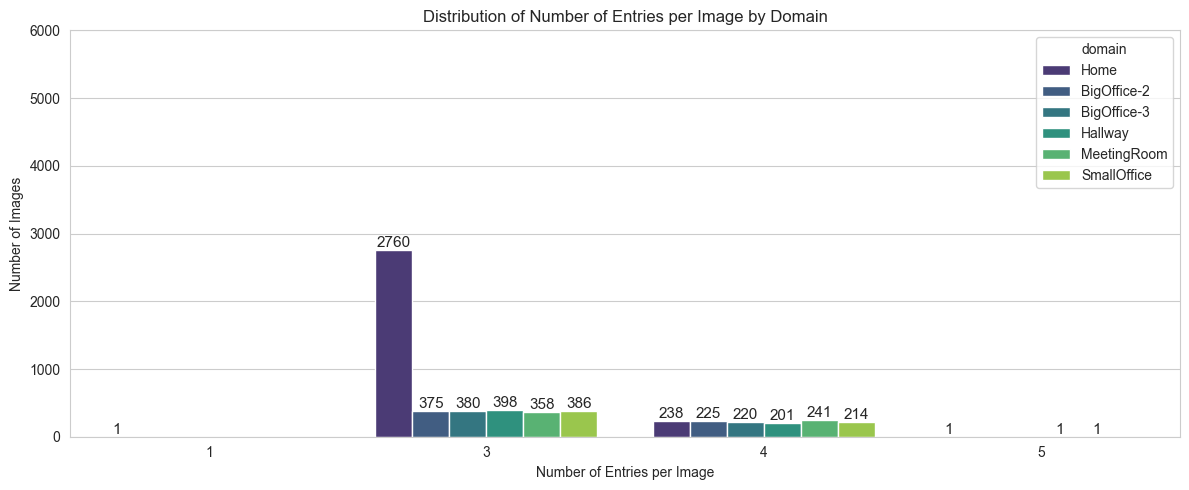

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

entries_per_image = raw_df.groupby(['robot', 'domain', 'image_ref']).size().reset_index(name='num_entries')
domain_counts = entries_per_image.groupby(['domain', 'num_entries']).size().reset_index(name='count')

plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=domain_counts,
    x='num_entries',
    y='count',
    hue='domain',
    hue_order = ['Home', 'BigOffice-2', 'BigOffice-3', 'Hallway', 'MeetingRoom',
       'SmallOffice'],
    palette='viridis'
)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,  # Slightly above the bar
            int(height),
            ha='center',
            va='bottom',
            fontsize=11
        )
ax.set_ylim(0, domain_counts['count'].sum())

plt.xlabel('Number of Entries per Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Number of Entries per Image by Domain')
plt.tight_layout()
plt.show()



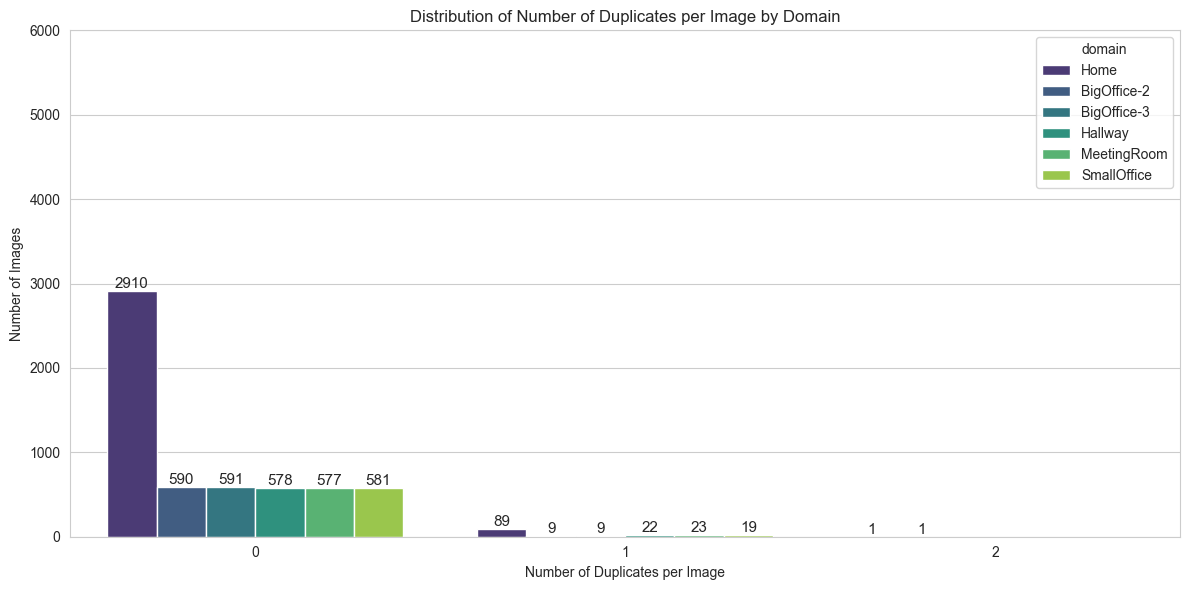

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

duplicated_rows = raw_df.duplicated(keep=False)
duplicates_per_index = duplicated_rows.groupby([raw_df['robot'], raw_df['domain'], raw_df['image_ref']]).sum()
duplicates_per_index = duplicates_per_index.apply(lambda x: max(x - 1, 0))

duplicates_per_index = duplicates_per_index.reset_index(name='num_duplicates')
domain_counts = duplicates_per_index.groupby(['domain', 'num_duplicates']).size().reset_index(name='count')


plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=domain_counts,
    x='num_duplicates',
    y='count',
    hue='domain',
    hue_order = ['Home', 'BigOffice-2', 'BigOffice-3', 'Hallway', 'MeetingRoom',
       'SmallOffice'],
    palette='viridis'
)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            int(height),
            ha='center',
            va='bottom',
            fontsize=11
        )

# Set y-axis max to total number of duplicates
ax.set_ylim(0, domain_counts['count'].sum())

plt.xlabel('Number of Duplicates per Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Number of Duplicates per Image by Domain')
plt.tight_layout()
plt.show()


## CL Baseline Model